# TensorFlow Hub Transfer Learning

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import math
from hub_functions import textblob_dataugm, df_to_dataset, sentence_to_dataset, predict4_tfdataset, multiclass_confusion_mat, plot_history

## 1A. Downloading the Dataset with groups

In [2]:
## Import Emoji description dataset
improved_clusters_df = pd.read_csv('file_name.csv')

In [3]:
improved_clusters_df.sample(3, random_state=123)

,Unnamed: 0,Unnamed: 0.1,emoji_symbol,emoji_name,emoji_code,emoji_description,label_name,label_num
189,189,189,🙎,Person Pouting,U+1F64E,"A person with a serious expression,showing mil...",Person-activity,6
1052,1052,1052,💻,Laptop,U+1F4BB,A laptop personal computer. Depicted as a blac...,Objects,5
954,954,954,⚓,Anchor,U+2693,"A metal device, dropped out of a boat to preve...",Travel & Places,10


#### Class distribution

In [4]:
base_color = sb.color_palette()[0]

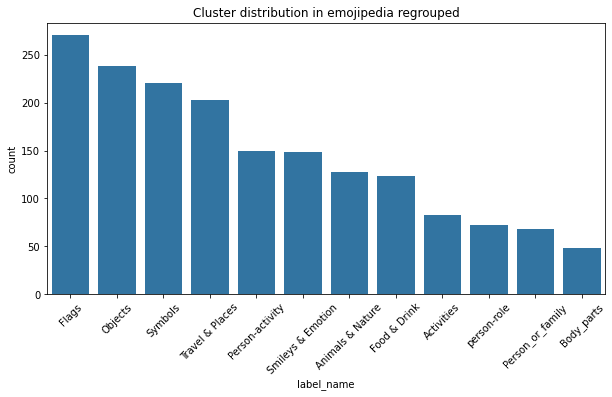

In [5]:
plt.figure(figsize = [10,5])
sb.countplot(data=improved_clusters_df,x='label_name',order=improved_clusters_df.label_name.value_counts().index,
            color=base_color)
plt.xticks(rotation=45)
plt.title('Cluster distribution in emojipedia regrouped');

#### Dictionnary label_num to label_name

In [6]:
# Building a dictionnary label_num to label_name
num_2_name = improved_clusters_df[['label_num', 'label_name']].copy()

In [7]:
num2name = num_2_name.groupby(by='label_name').first()

In [8]:
num2name

,label_num
label_name,
Activities,0
Animals & Nature,1
Body_parts,2
Flags,3
Food & Drink,4
Objects,5
Person-activity,6
Person_or_family,7
Smileys & Emotion,8


In [9]:
num_2_name_lookup = dict(zip(list(num2name.label_num),list(num2name.index)))

In [10]:
df = improved_clusters_df[["emoji_description", "label_num"]].copy()

In [11]:
df.sample(3, random_state=123)

,emoji_description,label_num
189,"A person with a serious expression,showing mil...",6
1052,A laptop personal computer. Depicted as a blac...,5
954,"A metal device, dropped out of a boat to preve...",10


In [12]:
# Taking a copy of the dataframe
dataframe = improved_clusters_df[["emoji_description", "label_num"]].copy()

In [13]:
dataframe.label_num.nunique()

12

## 1B. Data Augmentation

###  Using TextBlob

In [14]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


## 2. Dataset preparation

#### Creating a train and test dataset from a Pandas DataFrame

source : https://www.tensorflow.org/tutorials/structured_data/feature_columns

 >  Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly.

In [15]:
dataframe.sample(3)

,emoji_description,label_num
438,"A graduation cap, worn on the head of students...",5
508,"A kangaroo, amarsupialwith a large tail and le...",1
1183,"A bed, made up for sleeping in ahouse,hotel, o...",5


In [16]:
# Updating the names of the columns
dataframe.columns = ['features','target']

In [17]:
dataframe.head(1)

,features,target
0,"A yellow face with simple, open eyes and a bro...",8


#### Dividing in Train and Test Set








In [18]:
# Dividing in train and test set WITHOUT DATA AUGMENTATION
train, test = train_test_split(dataframe, test_size=0.2,random_state=123)

print(len(train), 'train examples')
print(len(test), 'test examples')

1401 train examples
351 test examples


#### Divinding in Train and Test Set in case of Data Augmentation

> As the data augmentation, will happen on the train set, here we take a test set that's a bit bigger 

In [19]:
# Dividing in train and test set (Not EXECUTING IF LOADING THE DATA)
#train_augm, test_30pct = train_test_split(dataframe, test_size=0.3,random_state=123) # Taking this time a bigger Test Set

#print(len(train_augm), 'train examples')
#print(len(test_30pct), 'test examples')

In [20]:
# DUBBLE THE TRAIN SET BY ADDING TRANSLATION EN-FR-EN
#train_augm = textblob_dataugm(train_augm)   # You can run it in case not possible to load the 

In [21]:
# Downloading the dataframe locally (Only first time to keep the data locally )
#from google.colab import files
#train_augm.to_csv('train_augm.csv') 
#test_30pct.to_csv('test_30pct.csv')
#files.download('train_augm.csv')
#files.download('test_30pct.csv')

In [22]:
train_augm = pd.read_csv('train_augm.csv')

In [23]:
test_30pct = pd.read_csv('test_30pct.csv')

In [24]:
# Removing first column
train_augm.drop(columns=['Unnamed: 0'],inplace=True)
test_30pct.drop(columns=['Unnamed: 0'],inplace=True)

In [25]:
print(train_augm.shape)

train_augm.sample(10,random_state=123)

(2452, 2)


,features,target
638,The Woman Standing emoji is aZWJ sequencecombi...,6
1195,The Man in Manual Wheelchair emoji is aZWJ seq...,6
556,TheAries astrological sign in the Zodiac. This...,9
1998,"A ball of yarn, used to knit a scarf. Color va...",0
1059,"Apoodle, a popular dog breed with curly hair, ...",1
1205,"CJK Ideographs are characters used in Chinese,...",9
45,"The flag forMarshall Islands, which may show a...",3
993,"A hunk of unspecified meat on a white bone, as...",4
1689,Dark cross button,9
2311,"A magnetic compass, used for navigation. Usual...",10


#### Creating an input pipeline using tf.data 

> Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

#### DATASETS ACTUALLY USED IN THE DIFFERENT MODELS HEREUNDER

In [26]:
# Test without the Batch => THAT WILL BE USED AS INPUT FOR THE DL MODEL (Here WITHOUT DATA AUGMENTATION)
train_ds_nbatch = df_to_dataset(train, batching=False)
test_ds_nbatch = df_to_dataset(test, batching=False)

(1401,) (1401,)
(351,) (351,)


In [27]:
# Test without the Batch => THAT WILL BE USED AS INPUT FOR THE DL MODEL (Here WITH DATA AUGMENTATION)
train_ds_nbatch_dAug = df_to_dataset(train_augm, batching=False)
test_ds_nbatch_dAug = df_to_dataset(test_30pct, batching=False)

(2452,) (2452,)
(526,) (526,)


## 3. Tensorflow Hub

source : https://www.tensorflow.org/tutorials/keras/text_classification_with_hub





In [28]:
# 20 dimension embedding
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
embedding_layer = hub.KerasLayer(
    embedding,
    input_shape=[],
    dtype=tf.string,
    trainable=True
)

In [29]:
# 128 dimensions embedding
embedding_128D = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
embedding_layer_128D = hub.KerasLayer(
    embedding_128D,
    input_shape=[],
    dtype=tf.string,
    trainable=True
)

In [30]:
train_batch, labels_batch = next(iter(train_ds_nbatch.batch(1)))

In [31]:
train_batch

<tf.Tensor: id=381, shape=(1,), dtype=string, numpy=
array([b'A hand waving most commonly used to say \xe2\x80\x9chello\xe2\x80\x9d or \xe2\x80\x9cgoodbye\xe2\x80\x9d.This emoji can be used to convey a sense ofnot being friends any morewhen used on WeChat in China.'],
      dtype=object)>

In [32]:
# Example applying the sentence embedding  (20 dimensions)
embedding_layer(train_batch)

<tf.Tensor: id=392, shape=(1, 20), dtype=float32, numpy=
array([[ 1.8382756 , -0.7690373 ,  1.8254778 ,  1.8147639 , -1.7245224 ,
        -1.3472315 , -0.45811465,  1.4849725 ,  1.4457822 , -0.1137108 ,
        -0.52680266,  0.8458329 , -1.2888417 ,  0.1990101 , -1.6941395 ,
         0.20936193,  1.5886298 , -1.0156169 , -1.6457886 , -0.76618385]],
      dtype=float32)>

In [33]:
# Example of applying the the sentence embedding (128 dimensions)
embedding_layer_128D(train_batch)

<tf.Tensor: id=402, shape=(1, 128), dtype=float32, numpy=
array([[ 0.44029096, -0.06386893, -0.03310411, -0.02016458,  0.07948828,
        -0.07824828, -0.06809159, -0.15895861,  0.01151921,  0.213112  ,
        -0.05991688, -0.1521358 , -0.05165208, -0.14240707,  0.03228411,
        -0.06309823, -0.2301445 , -0.0183589 , -0.02832241,  0.2101821 ,
         0.12577672, -0.00516587, -0.01193814, -0.1907942 , -0.14577132,
        -0.24229717,  0.09646676, -0.0107595 ,  0.13106439, -0.12650844,
         0.16095573,  0.12696122,  0.06063062,  0.04702891, -0.09532529,
        -0.06284091, -0.12790427, -0.19872256,  0.15413015,  0.16233069,
        -0.07095021, -0.06367708,  0.00642254, -0.00171392,  0.16132462,
         0.09992629, -0.10866871, -0.06164761,  0.00256006, -0.16113715,
         0.09736976, -0.02734757, -0.090331  ,  0.06725945, -0.05317692,
         0.06240572, -0.01982243, -0.07184532,  0.11811458,  0.0112677 ,
        -0.13938898,  0.1332144 ,  0.1254423 ,  0.07048441,  0.017

### Building the Multi-class classification Model

#### Data Variables

In [34]:
# Data WITOUT DATA AUGMENTATION
train_data = train_ds_nbatch
test_data = test_ds_nbatch

In [35]:
# Data WITH DATA AUGMENTATION
train_data_augm = train_ds_nbatch_dAug
test_data_augm = test_ds_nbatch_dAug

In [36]:
# To be used to build the confusion matrix
test_conf, test_labels_conf = next(iter(test_ds_nbatch.batch(351)))

In [37]:
# To be used to build the confusion matrix
test_conf_augm, test_labels_conf_augm = next(iter(test_data_augm.batch(526)))

#### Prepa data 


In [38]:
test

,features,target
189,"A person with a serious expression,showing mil...",6
1052,A laptop personal computer. Depicted as a blac...,5
954,"A metal device, dropped out of a boat to preve...",10
472,"The face of aunicorn, a mythical creature in t...",1
147,A mechanical or prosthetic leg.Mechanical Legw...,2
...,...,...
1636,"The flag for St. Martin, which may show as the...",3
169,The Man: Curly Hair emoji is aZWJ sequencecomb...,7
1541,"The flag for Costa Rica, which may show as the...",3
489,"A giraffe, the tallest animal on Earth, with s...",1


#### A. Base Model


In [39]:
# Setting up Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

# Creating an early stopping object early_stopping 
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    min_delta=0.001, 
    mode='auto'
)

**EarlyStopping() has a few options and by default:**
> - _monitor='val_loss':_ 
> 
>> to use validation loss as performance measure to terminate the training.
> - _patience=0:_ 
> 
>> is the number of epochs with no improvement. The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.
> 
> - _min_delta:_ 
>
>> Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
> 
>-  _mode='auto':_
> 
>> Should be one of auto, min or max. In 'min' mode, training will stop when the quantity monitored has stopped decreasing; in 'max' mode it will stop when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.

##### I. WITHOUT DATA AUGMENTATION

In [40]:
base_model = models.Sequential()
base_model.add(embedding_layer)
base_model.add(layers.Dense(100, activation="relu"))
base_model.add(layers.Dense(12, activation="softmax"))
base_model.summary()

base_model.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 403,332
Trainable params: 403,332
Non-trainable params: 0
_________________________________________________________________


In [41]:
base_history = base_model.fit(
    train_data.cache().batch(32),
    epochs=50,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/50
44/44 [==============================] - 1s 24ms/step - loss: 2.1975 - accuracy: 0.2670 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 1.6975 - accuracy: 0.4454 - val_loss: 1.5457 - val_accuracy: 0.4929
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 1.4225 - accuracy: 0.5432 - val_loss: 1.3400 - val_accuracy: 0.5641
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 1.2217 - accuracy: 0.6203 - val_loss: 1.1977 - val_accuracy: 0.6068
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 1.0656 - accuracy: 0.6767 - val_loss: 1.0941 - val_accuracy: 0.6353
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 0.9395 - accuracy: 0.7188 - val_loss: 1.0159 - val_accuracy: 0.6610
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 0.8350 - accuracy: 0.7616 - val_loss: 0.9567 - val_accuracy: 0.6724
Epoch 8/50


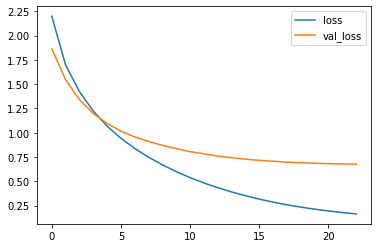

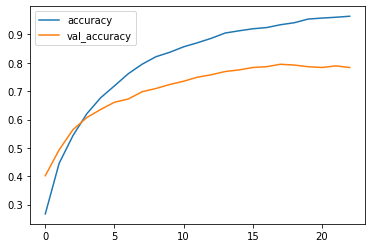

In [42]:
plot_history(base_history)

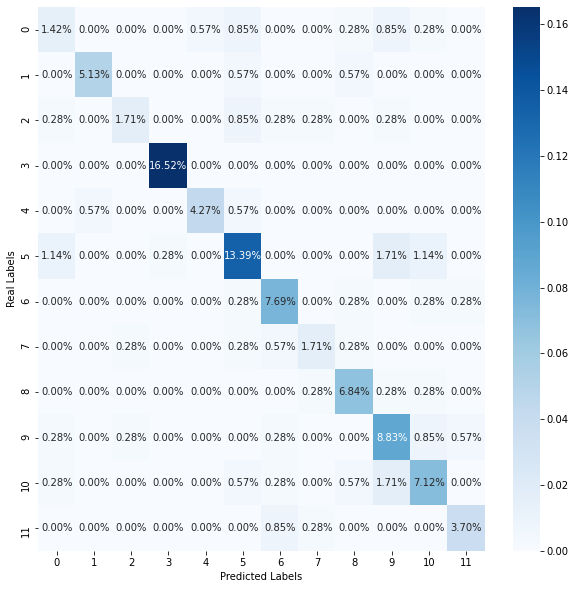

In [43]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model)

In [44]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [45]:
predict4_tfdataset(test_batch, test_labels_batch, base_model, num_2_name_lookup)

The sentence is : b'A staff (or stave) showing atreble clefand five horizontal lines.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Symbols

The sentence is : b"A classic snowman, asFrosty the Snowman, withsnowflakesfalling on it.Depicted as a snowman, facing forward, made from two or three large snowballs and stick arms, dressed with atop hat, acarrotnose, coal eyes, and two or three buttons on its torso. Sometimes shown with a smile and a redscarf.Often used for various content concerningwinterfun andChristmastime.Vendors implement the same figure for their\xe2\x9b\x84 Snowman Without Snow, which does not have snowflakes.Google\xe2\x80\x99s snowman is wearing greengloves, thoguh its snowmanpreviouslylacked any attire.Samsung'spreviously lacked a hat.This snowman predates Unicode emoji support, which explains why it may display as theblack-and-whiteoutlineof a snowman."
The REAL CATEGORY is : Travel & Places versus the PREDICTED CATEGORY : Activities

The sentence is

##### II. WITH DATA AUGMENTATION

In [46]:
base_model_augm = models.Sequential()
base_model_augm.add(embedding_layer)
base_model_augm.add(layers.Dense(100, activation="relu"))
base_model_augm.add(layers.Dense(12, activation="softmax"))
base_model_augm.summary()

base_model_augm.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1212      
Total params: 403,332
Trainable params: 403,332
Non-trainable params: 0
_________________________________________________________________


In [47]:
base_history_augm = base_model_augm.fit(
    train_data_augm.cache().batch(32),
    epochs=50,
    validation_data=test_data_augm.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/50
77/77 [==============================] - 1s 10ms/step - loss: 1.6936 - accuracy: 0.4629 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 0.8913 - accuracy: 0.7838 - val_loss: 0.8053 - val_accuracy: 0.7586
Epoch 3/50
77/77 [==============================] - 0s 4ms/step - loss: 0.5663 - accuracy: 0.8695 - val_loss: 0.6611 - val_accuracy: 0.7966
Epoch 4/50
77/77 [==============================] - 0s 4ms/step - loss: 0.4065 - accuracy: 0.9074 - val_loss: 0.5731 - val_accuracy: 0.8194
Epoch 5/50
77/77 [==============================] - 0s 5ms/step - loss: 0.3153 - accuracy: 0.9303 - val_loss: 0.5304 - val_accuracy: 0.8403
Epoch 6/50
77/77 [==============================] - 0s 5ms/step - loss: 0.2558 - accuracy: 0.9421 - val_loss: 0.5076 - val_accuracy: 0.8460
Epoch 7/50
77/77 [==============================] - 0s 5ms/step - loss: 0.2134 - accuracy: 0.9527 - val_loss: 0.4885 - val_accuracy: 0.8555
Epoch 8/50


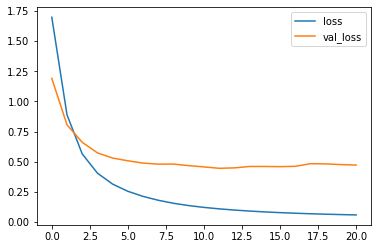

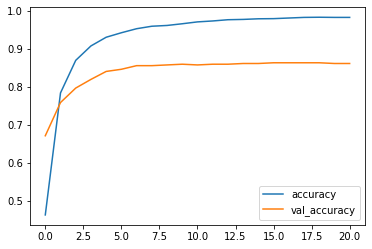

In [48]:
plot_history(base_history_augm)

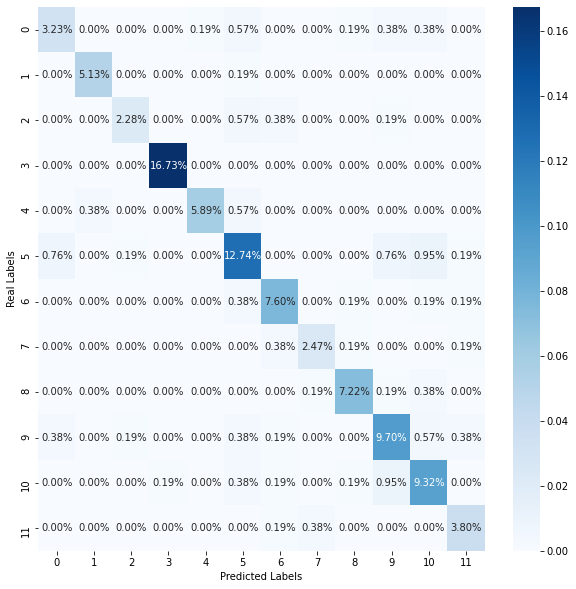

In [49]:
multiclass_confusion_mat(test_conf_augm, test_labels_conf_augm, base_model_augm)

In [50]:
# TAKING A BATCH of the TEST DATA
test_batch_augm, test_labels_batch_augm = next(iter(test_ds_nbatch_dAug.shuffle(300).batch(10)))

In [51]:
predict4_tfdataset(test_batch_augm, test_labels_batch_augm, base_model_augm, num_2_name_lookup)

The sentence is : b'The Man Vampire emoji is aZWJ sequencecombining\xf0\x9f\xa7\x9bVampire,\xe2\x80\x8dZero Width Joinerand\xe2\x99\x82Male Sign.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Person-activity versus the PREDICTED CATEGORY : Person-activity

The sentence is : b'A high-heeled shoe, primarily worn bywomen. Generally found in a context which requires formal dress, suchassocial occasions, or some work places.Displayed in red on most platforms, though the color may vary.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'The male version of the\xf0\x9f\x8f\x8aSwimmeremoji. Currently identical in appearance to the non-gendered base emoji.The Man Swimming emoji is aZWJ sequencecombining\xf0\x9f\x8f\x8aPerson Swimming,\xe2\x80\x8dZero Width Joinerand\xe2\x99\x82Male Sign.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Person-activity versus the PREDICTED CATEGORY : Pers

#### B. BASE_MODEL but with EMBEDDINLAYER Dimension 128D

##### I. Without Regularization

In [52]:
base_model_128D = models.Sequential()
base_model_128D.add(embedding_layer_128D)
base_model_128D.add(layers.Dense(100, activation="relu"))
base_model_128D.add(layers.Dense(12, activation="softmax"))
base_model_128D.summary()

base_model_128D.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

base_history_128D = base_model_128D.fit(
    train_data.cache().batch(32),
    epochs=15,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_5 (Dense)              (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
44/44 [==============================] - 57s 1s/step - loss: 2.1150 - accuracy: 0.3976 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
44/44 [==============================] - 56s 1s/step - loss: 1.3595 - accuracy: 0.6781 - val_loss: 1.1760 - val_accuracy: 0.6923
Epoch 3/15
44/44 [==============================] - 57s 1s/step - loss: 0.7593 - a

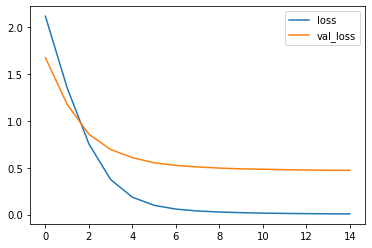

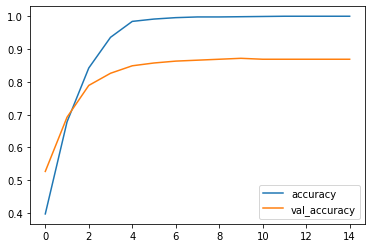

In [53]:
plot_history(base_history_128D)

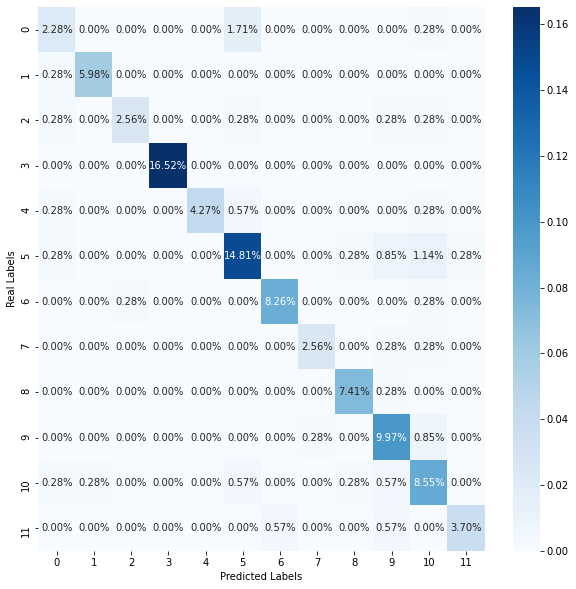

In [54]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D)

In [55]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [56]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D, num_2_name_lookup)

The sentence is : b'The cooked sausage of a hot dog in a slicedbunand drizzled with yellow mustard, as eaten at abaseballgame.'
The REAL CATEGORY is : Food & Drink versus the PREDICTED CATEGORY : Food & Drink

The sentence is : b'A yellow or gold colored love-heart.Inexplicably, this displayed as a pinkhairy hearton Android 4.4.OnSnapchat,thisemoji next to a contactdenotes a person that you snap the most, and who also snaps you the most (#1 best friend). The yellow#1 BF heartturns into ared heartafter two weeks.A bug in October 2019 has thisyellow heart emoji showing instead of\xf0\x9f\x92\x95 for some Snapchat users.'
The REAL CATEGORY is : Smileys & Emotion versus the PREDICTED CATEGORY : Smileys & Emotion

The sentence is : b'A test tube, as used to conduct chemical experiments in a laboratory. Depicted as a clear cylinder, open at one end and containing a green liquid. Positioned at a 45\xc2\xb0 angle.May be used for various content concerning chemistry and science more generally. 

II. With Regularization

In [57]:
# hyperparameters:
factor = 0.001
rate =  0.3

##### 1. Only L2 Regularization

In [58]:
base_model_128D_l2 = models.Sequential()
base_model_128D_l2.add(embedding_layer_128D)
base_model_128D_l2.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_l2.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_l2.summary()

base_model_128D_l2.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

base_history_128D_l2 = base_model_128D_l2.fit(
    train_data.cache().batch(32),
    epochs=12,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_6 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_7 (Dense)              (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
44/44 [==============================] - 57s 1s/step - loss: 1.8364 - accuracy: 0.6652 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/12
44/44 [==============================] - 57s 1s/step - loss: 0.7698 - accuracy: 0.9308 - val_loss: 0.9716 - val_accuracy: 0.8205
Epoch 3/12
44/44 [==============================] - 56s 1s/step - loss: 0.3735 - a

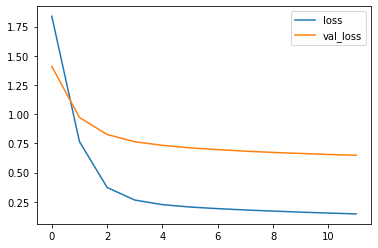

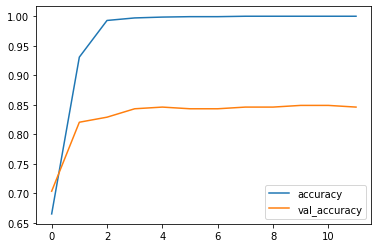

In [59]:
plot_history(base_history_128D_l2)

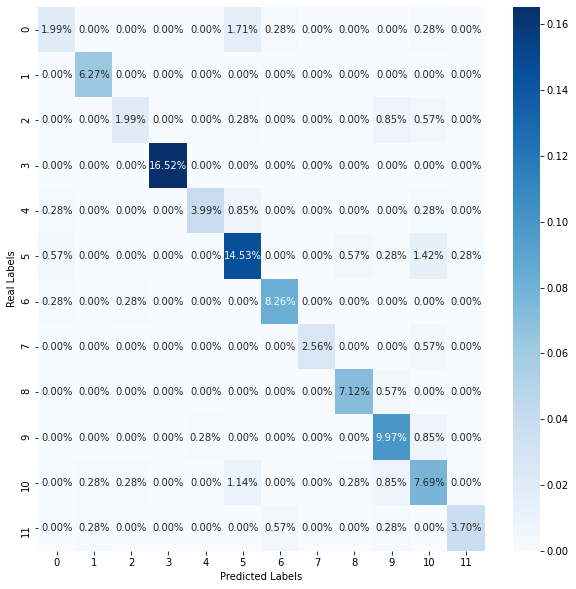

In [60]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D_l2)

In [61]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [62]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_l2, num_2_name_lookup)

The sentence is : b'A style of boot commonly worn on long walks or for hiking. Generally distinct from other footwear-related emojis by the considerable grip on the sole of the shoe.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'A family withtwomothers,and two sons.The Family: Woman, Woman, Boy, Boy emoji is aZWJ sequencecombining\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joiner,\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joiner,\xf0\x9f\x91\xa6Boy,\xe2\x80\x8dZero Width Joinerand\xf0\x9f\x91\xa6Boy.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Person_or_family versus the PREDICTED CATEGORY : Person_or_family

The sentence is : b'A two-piece bikini, worn at the beach, pool, or on vacation at atropical destination.Shown in a variety of colors and patterns across different platforms.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'Tooth'
The REAL CATEGORY is 

#### 2. L2 and Dropout with EarlyStopping

In [63]:
base_model_128D_reg = models.Sequential()
base_model_128D_reg.add(embedding_layer_128D)
base_model_128D_reg.add(layers.Dropout(rate))
base_model_128D_reg.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg.add(layers.Dropout(rate))
base_model_128D_reg.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg.summary()

base_model_128D_reg.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Applying Early Stopping
base_history_128D_reg = base_model_128D_reg.fit(
    train_data.cache().batch(32),
    epochs=30,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/30
44/44 [==============================] - 54s 1s/step - loss: 1.8957 - accuracy: 0.5596 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
44/44 [==============================] - 56s 1s/step - loss: 0.8830 - accuracy: 0.8837 - val_loss: 0.9784 - val_accuracy: 0.7977
Epoch 3/30
44/44 [==============================] - 55s 1s/step - loss: 0.4665 - accuracy: 0.9622 - val_loss: 0.8168 - val_accuracy: 0.8148
Epoch 4/30
44/44 [==============================] - 55s 1s/step - loss: 0.3184 - accuracy: 0.9879 - val_loss: 0.7393 - val_accuracy: 0.8405
Epoch 5/30
44/44 [==============================] - 54s 1s/step - loss: 0.2510 - accuracy: 0.9929 - val_loss: 0.7098 - val_accuracy: 0.8519
Epoch 6/30
44/44 [==============================] - 56s 1s/step - loss: 0.2315 - accuracy: 0.9957 - val_loss: 0.6887 - val_accuracy: 0.8519
Epoch 7/30
44/44 [==============================] - 55s 1s/step - loss: 0.2063 - accuracy: 0.9986 - val_loss: 0.6732 - val_accuracy: 0.8462
Epoch 8/30
4

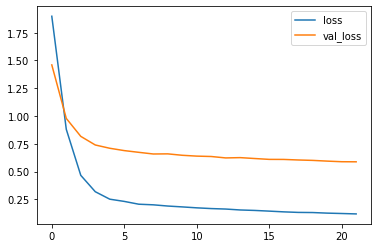

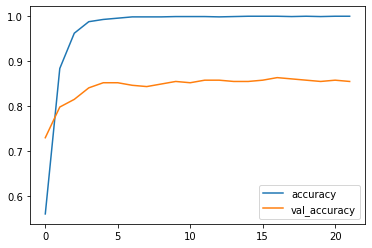

In [65]:
plot_history(base_history_128D_reg)

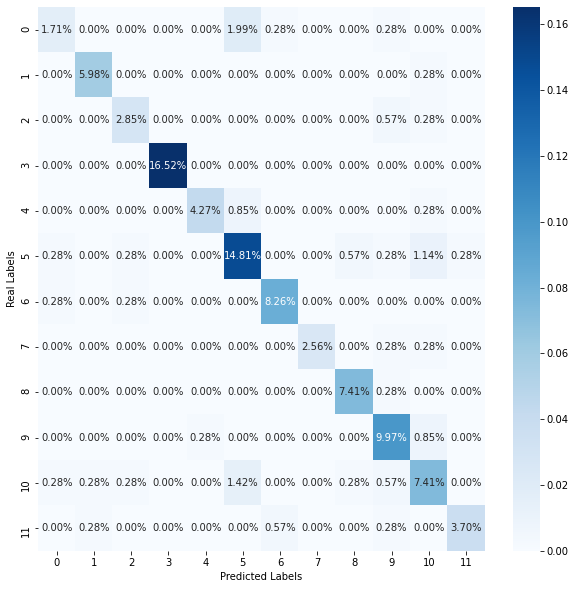

In [66]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D_reg)

In [67]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg, num_2_name_lookup)

The sentence is : b'A style of boot commonly worn on long walks or for hiking. Generally distinct from other footwear-related emojis by the considerable grip on the sole of the shoe.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'A family withtwomothers,and two sons.The Family: Woman, Woman, Boy, Boy emoji is aZWJ sequencecombining\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joiner,\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joiner,\xf0\x9f\x91\xa6Boy,\xe2\x80\x8dZero Width Joinerand\xf0\x9f\x91\xa6Boy.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Person_or_family versus the PREDICTED CATEGORY : Person_or_family

The sentence is : b'A two-piece bikini, worn at the beach, pool, or on vacation at atropical destination.Shown in a variety of colors and patterns across different platforms.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'Tooth'
The REAL CATEGORY is 

##### I. WITH DATA AUGMENTATION

In [68]:
base_model_128D_reg_augm = models.Sequential()
base_model_128D_reg_augm.add(embedding_layer_128D)
base_model_128D_reg_augm.add(layers.Dropout(rate))
base_model_128D_reg_augm.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg_augm.add(layers.Dropout(rate))
base_model_128D_reg_augm.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg_augm.summary()

base_model_128D_reg_augm.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Applying Early Stopping
base_history_128D_reg_augm = base_model_128D_reg_augm.fit(
    train_data_augm.cache().batch(32),
    epochs=30,
    validation_data=test_data_augm.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/30
77/77 [==============================] - 93s 1s/step - loss: 1.4640 - accuracy: 0.6611 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
77/77 [==============================] - 92s 1s/step - loss: 0.5196 - accuracy: 0.9364 - val_loss: 0.5430 - val_accuracy: 0.8878
Epoch 3/30
77/77 [==============================] - 92s 1s/step - loss: 0.3325 - accuracy: 0.9727 - val_loss: 0.5093 - val_accuracy: 0.8954
Epoch 4/30
77/77 [==============================] - 91s 1s/step - loss: 0.2758 - accuracy: 0.9825 - val_loss: 0.4853 - val_accuracy: 0.8916
Epoch 5/30
77/77 [==============================] - 91s 1s/step - loss: 0.2470 - accuracy: 0.9853 - val_loss: 0.4630 - val_accuracy: 0.8973
Epoch 6/30
77/77 [==============================] - 95s 1s/step - loss: 0.2236 - accuracy: 0.9878 - val_loss: 0.4655 - val_accuracy: 0.8935
Epoch 7/30
77/77 [==============================] - 94s 1s/step - loss: 0.2103 - accuracy: 0.9918 - val_loss: 0.4487 - val_accuracy: 0.9030
Epoch 8/30
7

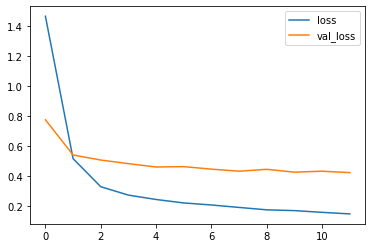

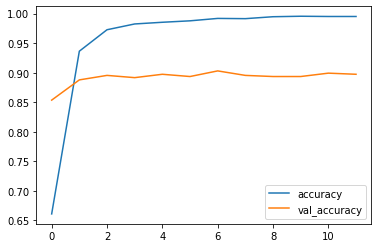

In [70]:
plot_history(base_history_128D_reg_augm)

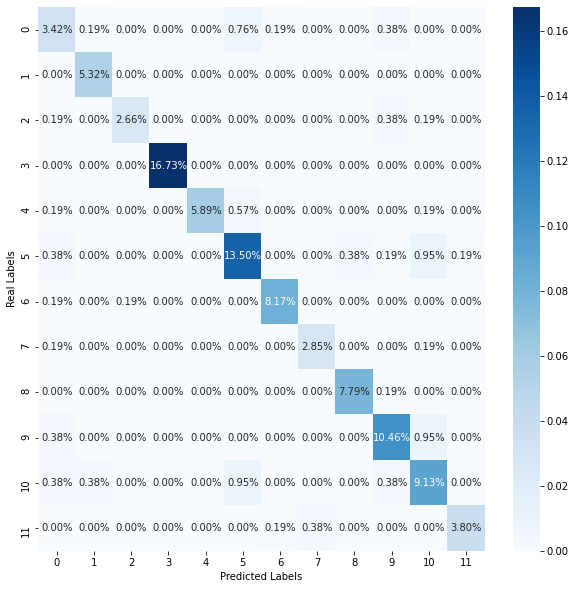

In [71]:
multiclass_confusion_mat(test_conf_augm, test_labels_conf_augm, base_model_128D_reg_augm)

In [72]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg, num_2_name_lookup)

The sentence is : b'A style of boot commonly worn on long walks or for hiking. Generally distinct from other footwear-related emojis by the considerable grip on the sole of the shoe.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'A family withtwomothers,and two sons.The Family: Woman, Woman, Boy, Boy emoji is aZWJ sequencecombining\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joiner,\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joiner,\xf0\x9f\x91\xa6Boy,\xe2\x80\x8dZero Width Joinerand\xf0\x9f\x91\xa6Boy.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Person_or_family versus the PREDICTED CATEGORY : Person_or_family

The sentence is : b'A two-piece bikini, worn at the beach, pool, or on vacation at atropical destination.Shown in a variety of colors and patterns across different platforms.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'Tooth'
The REAL CATEGORY is 

#### II. Trying with less units in the Dense Layer as still overfitting

In [73]:
base_model_128D_reg_less = models.Sequential()
base_model_128D_reg_less.add(embedding_layer_128D)
base_model_128D_reg_less.add(layers.Dropout(rate))
# REDUCING THE AMOUNT OF UNITS IN HIDDEN LAYER
base_model_128D_reg_less.add(layers.Dense(40,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg_less.add(layers.Dropout(rate))
base_model_128D_reg_less.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg_less.summary()

base_model_128D_reg_less.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

# Applying Early Stopping
base_history_128D_reg_less = base_model_128D_reg_less.fit(
    train_data.cache().batch(32),
    epochs=30,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                5160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 12)                492       
Total params: 124,648,340
Trainable params: 124,648,340
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
44/44 [==============================] - 63s 1s/step - loss: 2.0622 - accuracy: 0.3876 - val_lo

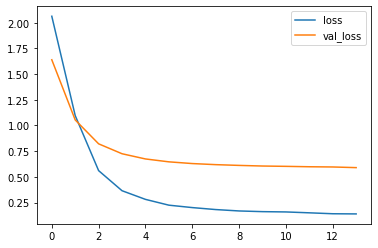

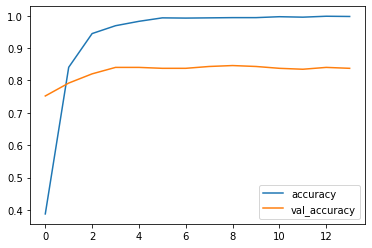

In [74]:
plot_history(base_history_128D_reg_less)

In [76]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg_less, num_2_name_lookup)

The sentence is : b'A style of boot commonly worn on long walks or for hiking. Generally distinct from other footwear-related emojis by the considerable grip on the sole of the shoe.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'A family withtwomothers,and two sons.The Family: Woman, Woman, Boy, Boy emoji is aZWJ sequencecombining\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joiner,\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joiner,\xf0\x9f\x91\xa6Boy,\xe2\x80\x8dZero Width Joinerand\xf0\x9f\x91\xa6Boy.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Person_or_family versus the PREDICTED CATEGORY : Person_or_family

The sentence is : b'A two-piece bikini, worn at the beach, pool, or on vacation at atropical destination.Shown in a variety of colors and patterns across different platforms.'
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'Tooth'
The REAL CATEGORY is 